## Part 1 Time Series Analysis

In [183]:
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

### Stationarity
Differences need to be applied if data is not stationary.

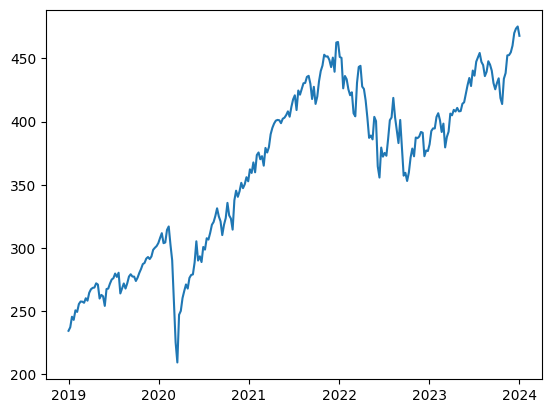

In [184]:
msft = yf.Ticker("SPY")

# get all stock info
# msft.info

# get historical market data
df = msft.history(period='5y', interval='1wk')
df = df[['Close']]
plt.plot(df)

In [185]:
df.head(10)

,Close
Date,
2019-01-01 00:00:00-05:00,234.428055
2019-01-08 00:00:00-05:00,237.211166
2019-01-15 00:00:00-05:00,245.560562
2019-01-22 00:00:00-05:00,243.072342
2019-01-29 00:00:00-05:00,250.629181
2019-02-05 00:00:00-05:00,249.394302
2019-02-12 00:00:00-05:00,255.614838
2019-02-19 00:00:00-05:00,257.596161
2019-02-26 00:00:00-05:00,257.485626


The adfuller test can help us do hypothesis testing on the stationarity

In [186]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(df):
    result=adfuller(df)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('Ho: Data is non-stationary')
    print('H1: Data is stationary')
    print()
    if result[1] <= 0.05:
        print("p < 0.05, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("p > 0.05, weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df)

ADF Test Statistic : -1.3657324251862002
p-value : 0.5985897631025879
#Lags Used : 0
Number of Observations : 261
Ho: Data is non-stationary
H1: Data is stationary

p > 0.05, weak evidence against null hypothesis,indicating it is non-stationary 


Look at the differences, taking the first order of difference will give us stationarity

In [187]:
first_order_difference = df - df.shift(1)
adfuller_test(first_order_difference.dropna())

ADF Test Statistic : -15.683202984178392
p-value : 1.4641021806576034e-28
#Lags Used : 0
Number of Observations : 260
Ho: Data is non-stationary
H1: Data is stationary

p < 0.05, strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


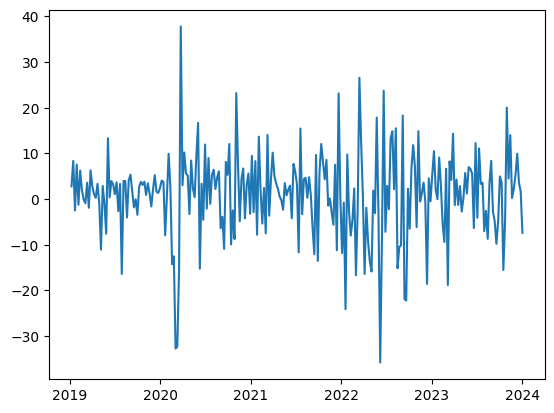

In [188]:
plt.plot(first_order_difference.index, first_order_difference.values)

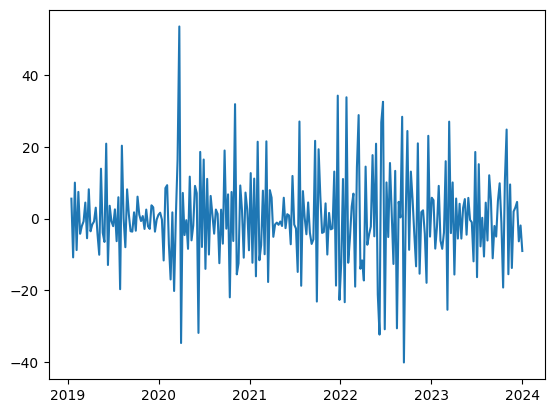

In [189]:
second_order_difference = first_order_difference - first_order_difference.shift(1)
plt.plot(second_order_difference.index, second_order_difference.values)

### Autocorrelation
We should plot autocorrelation based on the differences that we plan to use.

Note that this is on the actual values, it will only be useful if we are using d = 0

The autocorrelation plot shows the correlation between $y_t$ and $y_{t-k}$ with all the influencing variables removed. Here is an explanation from stack exchange
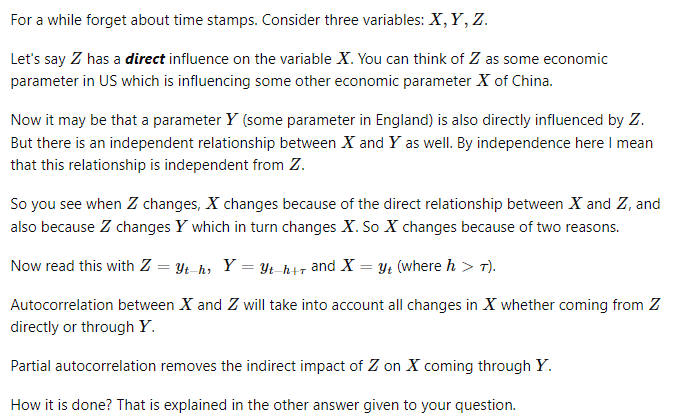



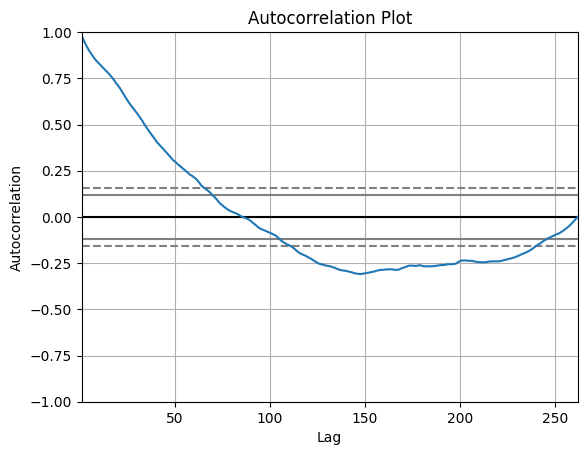

In [190]:
from pandas.plotting import autocorrelation_plot

ax = autocorrelation_plot(df)
ax.set_title('Autocorrelation Plot')
# ax.set_xlim(right=365)
# ax.set_ylim(bottom=0.5)
plt.show()

We can also use statsmodels' library

This time use the first order of difference, removed lag of 0 (the same value itself will have correlation of 1)

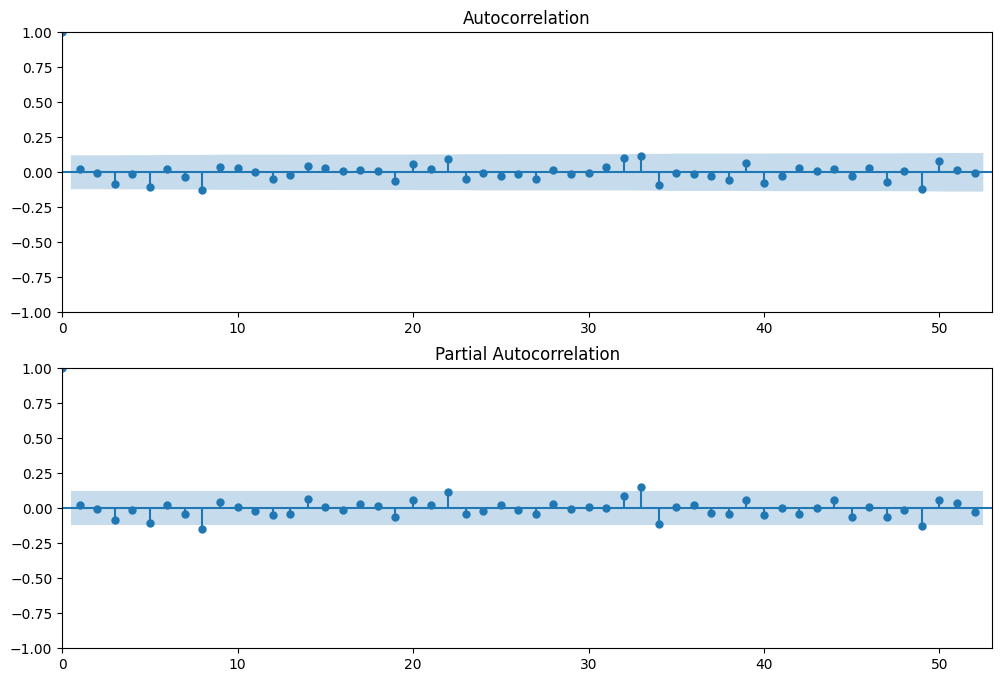

In [191]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
lags = 52

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(left=0, right = lags+1)
fig = sm.graphics.tsa.plot_acf(first_order_difference.dropna(),lags=lags,ax=ax1)

ax2 = fig.add_subplot(212)
ax2.set_xlim(left=0, right = lags+1)
fig = sm.graphics.tsa.plot_pacf(first_order_difference.dropna(),lags=lags,ax=ax2)

### pdq of ARIMA
p: The lag order, representing the number of lag observations incorporated in the model.

d: Degree of differencing, denoting the number of times raw observations undergo differencing.

q: Order of moving average, indicating the size of the moving average window.


In [207]:
# We need the index to be periods for ARIMA
time_series = df.copy()
time_series.index = time_series.index.to_period('W') 
# Doing this conversion on daily interval will mess up our dates because the original data did not include weekend dates

C:\Users\stell\AppData\Local\Temp\ipykernel_10984\549776980.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  time_series.index = time_series.index.to_period('W')


In [208]:
p = 1
d = 1 # From the graph above, data is not stationary, we will apply difference of 1
q = 1 

model = ARIMA(time_series, order=(p, d, q))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  262
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -953.290
Date:                Sun, 07 Jan 2024   AIC                           1912.580
Time:                        01:07:31   BIC                           1923.274
Sample:                    01-06-2019   HQIC                          1916.879
                         - 01-07-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0517      1.421      0.036      0.971      -2.734       2.838
ma.L1         -0.0202      1.442     -0.014      0.989      -2.846       2.806
sigma2        87.0980      5.670     15.361      0.0

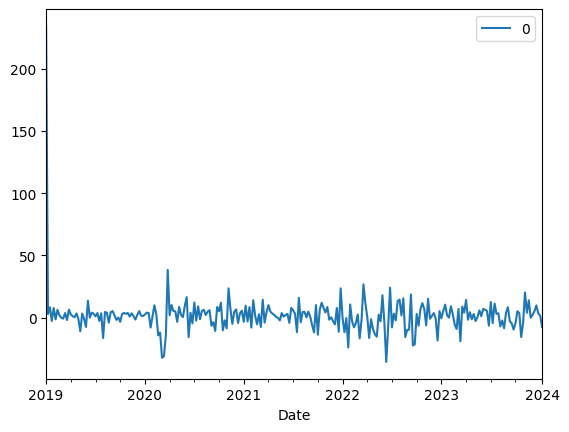

In [209]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

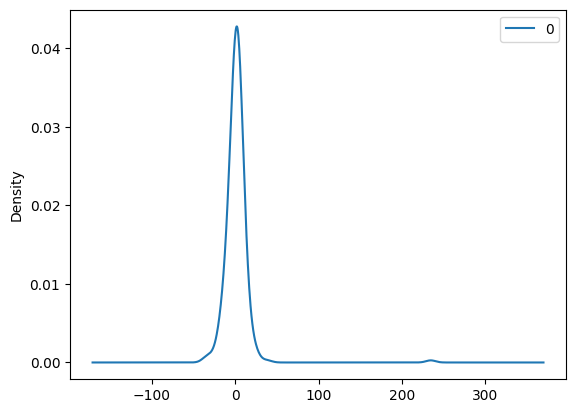

                0
count  262.000000
mean     1.756370
std     17.162806
min    -35.676456
25%     -3.451130
50%      2.024289
75%      5.348586
max    234.428055


In [210]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [211]:
evaluation = time_series.copy()
evaluation['fitted_values'] = model_fit.fittedvalues
# in_sample_predictions = model_fit.predict(start=1, end = 262, dynamic=False) # This is similar to fittedvalues
evaluation['residuals'] = model_fit.resid[1:]
evaluation

,Close,fitted_values,residuals
Date,,,
2018-12-31/2019-01-06,234.428055,0.000000,NaN
2019-01-07/2019-01-13,237.211166,234.428700,2.782467
2019-01-14/2019-01-20,245.560562,237.298986,8.261576
2019-01-21/2019-01-27,243.072342,245.825591,-2.753249
2019-01-28/2019-02-03,250.629181,242.999243,7.629938
...,...,...,...
2023-12-04/2023-12-10,460.124451,454.915607,5.208844
2023-12-11/2023-12-17,470.064178,460.292291,9.771887
2023-12-18/2023-12-24,473.649994,470.380967,3.269027


In [212]:
import numpy as np

def MSE(y, yhat, p):
    '''
    Calculate MSE, ignores the lag periods at the start
    '''
    y = y[p:]
    yhat = yhat[p:]
    return round(1/len(y)*(np.sum(y-yhat))**2, 3)

mse = MSE(evaluation['Close'], evaluation['fitted_values'], p)
print(f'Mean squared error for fitted values : {mse}')

Mean squared error for fitted values : 195.245


In [213]:
len(model_fit.fittedvalues)

262

Notice that ARIMA does not incorporate Seasonality, it is unable forecast well especially on stock data which high seasonality

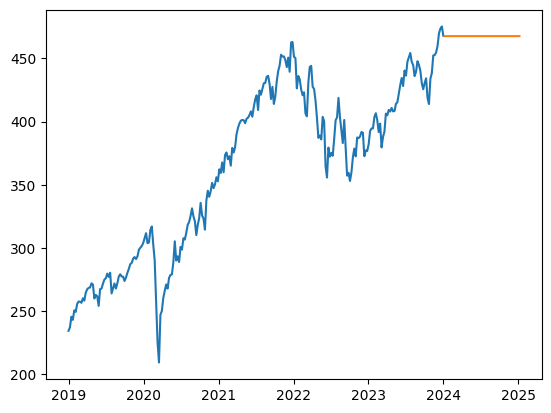

In [214]:
out_of_sample_predictions = model_fit.predict(start=len(df), end = len(df)+52, dynamic=False)
# Use .to_timestamp() to convert period back into timestamp for plotting
plt.plot(time_series.to_timestamp())
plt.plot(out_of_sample_predictions.to_timestamp())

## SARIMA - includes Seasonal Elements<br>
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.<br>
D: Seasonal difference order.<br>
Q: Seasonal moving average order.<br>
m: The number of time steps for a single seasonal period.

f:\python_stuff\financial_analysis_forecasting\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
f:\python_stuff\financial_analysis_forecasting\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


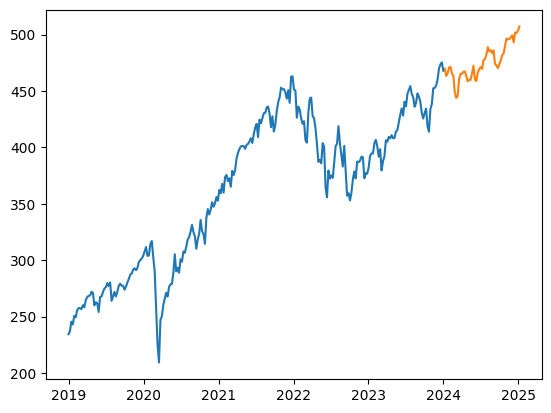

In [215]:
P = 1
D = 1
Q = 1
m = 52


model = sm.tsa.statespace.SARIMAX(time_series, order=(p, d, q),seasonal_order=(P,D,Q,m))
# model = ARIMA(time_series, order=(p, d, q),seasonal_order=(P,D,Q,m)) 

model_seasonality=model.fit()
out_of_sample_predictions = model_seasonality.predict(start=len(df), end = len(df)+52, dynamic=False)
# Use .to_timestamp() to convert period back into timestamp for plotting
plt.plot(time_series.to_timestamp())
plt.plot(out_of_sample_predictions.to_timestamp())

Lower MSE can be achieved with seasonality incorporated

In [218]:
mse = MSE(time_series.squeeze(), model_seasonality.fittedvalues, p)
print(f'Mean squared error for fitted values : {mse}')

Mean squared error for fitted values : 107.213
